In [1]:
from eaaw_graphlime_utils import *

import copy
import matplotlib.pyplot as plt
from   matplotlib.animation import FuncAnimation
from   IPython.display import HTML
import networkx as nx
import torch
from   torch_geometric.utils import to_networkx

torch.manual_seed(2)

In [2]:
data = prep_data()
train_indices = [i for i in range(len(data.train_mask.tolist())) if data.train_mask.tolist()[i]==True]
val_indices = [i for i in range(len(data.val_mask.tolist())) if data.val_mask.tolist()[i]==True]
test_indices = [i for i in range(len(data.test_mask.tolist())) if data.test_mask.tolist()[i]==True]

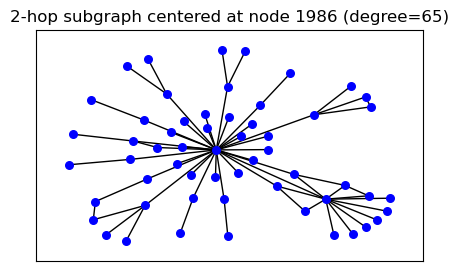

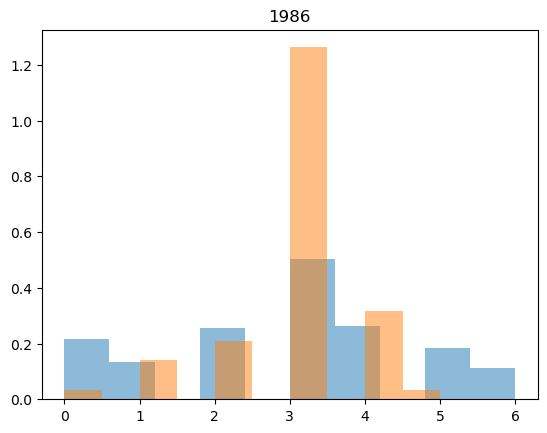

In [20]:
subgraph_kwargs        = {'d_reduce': None, 'num_hops': 2, 'node_index_to_watermark': None}

G = to_networkx(data, to_undirected=True)
degrees = dict(nx.degree(G))
train_degrees = {k:v for (k,v) in degrees.items() if k in train_indices}
sorted_degrees = {k: v for k, v in sorted(train_degrees.items(), key=lambda item: item[1], reverse=True)}

node_index_to_watermark = list(sorted_degrees.keys())[0]
[d_reduce, num_hops, _] = list(subgraph_kwargs.values())
data_sub, _, subgraph_node_idx = generate_subgraph(data, num_hops, node_index_to_watermark=node_index_to_watermark, d_reduce=d_reduce, show=True)


plt.title(node_index_to_watermark)
plt.hist(data.y,density=True,alpha=0.5)
plt.hist(data_sub.y,density=True,alpha=0.5)
plt.show()

In [13]:
node_classifier_kwargs  = {'lr': 0.05,'epochs':200}
subgraph_kwargs         = {'d_reduce': None, 'num_hops': 3, 'node_index_to_watermark': 1986}
densify_method          =None
epsilon                    =1e-1
watermark_loss_coefficient =0.5


data = prep_data()
if subgraph_kwargs['d_reduce'] is not None:
    data = aggregate_features(data, subgraph_kwargs['d_reduce'], method='max', ignore_trailing_features = True)

node_classifier, watermark, history,data_sub = train(data, watermark_loss_coefficient, epsilon, node_classifier_kwargs, subgraph_kwargs, densify_method)


Note -- subgraph features currently not aggregated. Defaulting to original number of node features.


  0%|          | 0/200 [00:00<?, ?it/s]

Epoch:   0, loss_primary = 1.945, loss_watermark = 71.680, B*W = 0.04265, train acc = 0.169, val acc = 0.196
Epoch:   1, loss_primary = 1.913, loss_watermark = 71.464, B*W = 0.37289, train acc = 0.319, val acc = 0.316
Epoch:   2, loss_primary = 1.894, loss_watermark = 70.961, B*W = 1.37791, train acc = 0.307, val acc = 0.312
Epoch:   3, loss_primary = 1.875, loss_watermark = 70.686, B*W = 1.92718, train acc = 0.314, val acc = 0.314
Epoch:   4, loss_primary = 1.854, loss_watermark = 70.566, B*W = 2.16849, train acc = 0.318, val acc = 0.316
Epoch:   5, loss_primary = 1.840, loss_watermark = 70.491, B*W = 2.33733, train acc = 0.319, val acc = 0.316
Epoch:   6, loss_primary = 1.833, loss_watermark = 70.408, B*W = 2.51628, train acc = 0.319, val acc = 0.316
Epoch:   7, loss_primary = 1.832, loss_watermark = 70.324, B*W = 2.68022, train acc = 0.319, val acc = 0.316
Epoch:   8, loss_primary = 1.828, loss_watermark = 70.248, B*W = 2.81551, train acc = 0.319, val acc = 0.316
Epoch:   9, loss_pr

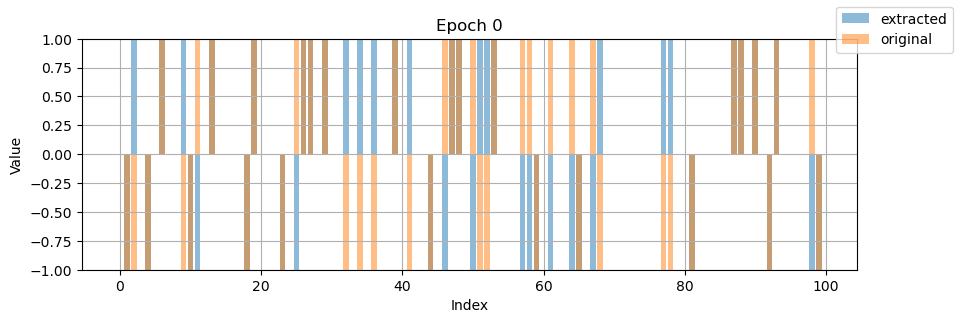

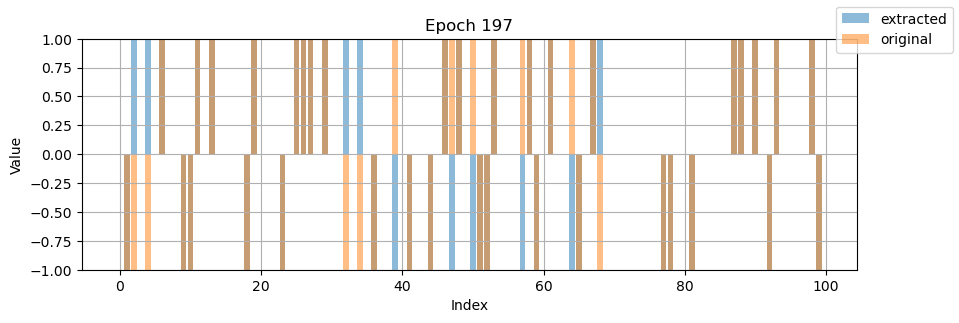

In [14]:
for i in [0,197]:
    fig, ax = plt.subplots(1, 1,figsize=(10,3))
    beta = history['betas'][i].clone().detach()
    extracted_watermark = copy.deepcopy(beta)#torch.sign(beta)
    extracted_watermark[extracted_watermark>0]=1
    extracted_watermark[extracted_watermark<0]=-1

    ax.bar(range(len(extracted_watermark[:100])),extracted_watermark[:100].numpy(),label='extracted',alpha=0.5)
    ax.bar(range(len(watermark[:100])),watermark[:100].numpy(),label='original',alpha=0.5)
    fig.legend()
    ax.set_title(f'Epoch {i if i>=0 else len(history['betas'])+i}')

    ax.set_xlabel('Index')  # X-axis label
    ax.set_ylabel('Value')  # Y-axis label
    ax.grid(True)  # Enable grid
    ax.set_ylim(-1,1)


tensor(0.0427)


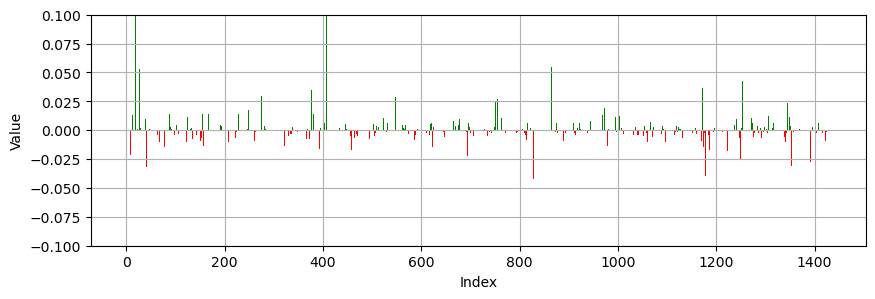

tensor(8.7566)


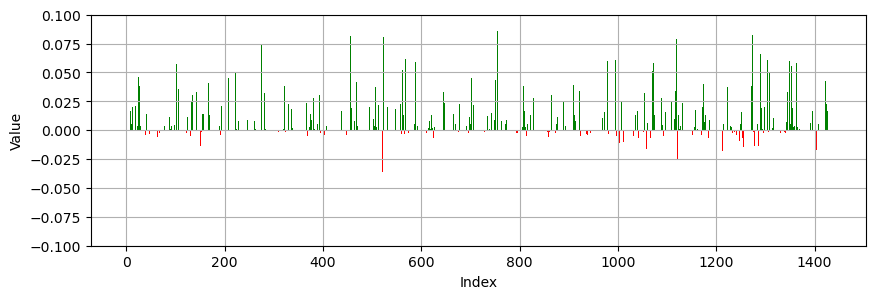

In [15]:
frame=-1
for frame in [0,-1]:
    fig, ax = plt.subplots(1, 1,figsize=(10,3))
    beta = history['betas'][frame].clone().detach()
    extracted_watermark = copy.deepcopy(beta)#torch.sign(beta)
    extracted_watermark[extracted_watermark>0]=1
    extracted_watermark[extracted_watermark<0]=-1

    same_betas, different_betas = copy.deepcopy(beta), copy.deepcopy(beta)
    same     = extracted_watermark==watermark
    not_same = extracted_watermark!=watermark

    same_betas[not_same]=0
    same_betas=torch.abs(same_betas)

    different_betas[same]=0
    different_betas=-torch.abs(different_betas)

    print(torch.sum(same_betas)+torch.sum(different_betas))
    

    ax.bar(range(len(same_betas)), same_betas.numpy(), color='green')
    ax.bar(range(len(different_betas)), different_betas.numpy(), color='red')
    ax.set_xlabel('Index')  # X-axis label
    ax.set_ylabel('Value')  # Y-axis label
    ax.grid(True)  # Enable grid
    ax.set_ylim(-0.1,0.1)
    plt.show()

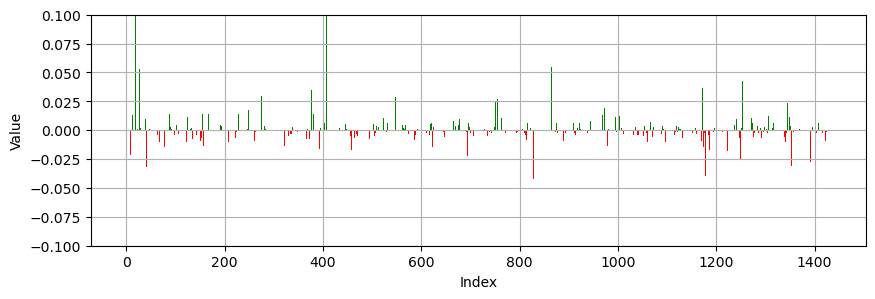

In [16]:

fig, ax = plt.subplots(1, 1,figsize=(10,3))
def update(frame):
    ax.clear()
    beta = history['betas'][frame].clone().detach()
    extracted_watermark = copy.deepcopy(beta)#torch.sign(beta)
    extracted_watermark[extracted_watermark>0]=1
    extracted_watermark[extracted_watermark<0]=-1

    same_betas, different_betas = copy.deepcopy(beta), copy.deepcopy(beta)
    same     = extracted_watermark==watermark
    not_same = extracted_watermark!=watermark
    
    same_betas[not_same]=0
    same_betas=torch.abs(same_betas)

    different_betas[same]=0
    different_betas=-torch.abs(different_betas)

    ax.bar(range(len(same_betas)), same_betas.numpy(), color='green')
    ax.bar(range(len(different_betas)), different_betas.numpy(), color='red')
    ax.set_xlabel('Index')  # X-axis label
    ax.set_ylabel('Value')  # Y-axis label
    ax.grid(True)  # Enable grid
    ax.set_ylim(-0.1,0.1)
    return ax,

ani = FuncAnimation(fig, update, frames=len(history['betas']))
HTML(ani.to_jshtml())


# 